# Credit Rating Classification
### Supervised Machine Learning with kNN, Decision Tree, and Random Forest

## Introduction

INTRODUCTION

In [22]:
# import packages
import pandas as pd
import numpy as np
import random
import math

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from random import seed

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image 
from pydot import graph_from_dot_data
from six import StringIO
from sklearn.ensemble import RandomForestClassifier

In [2]:
# import data
corporate_pd = pd.read_csv("../corporate_rating.csv")
corporate_pd.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


In order to perform analysis on categorical data, we will convert the ratings to numerical values. The order of ratings and their corresponding value are listed below in descending order.
- AAA: 1
- AA: 2
- A: 3
- BBB: 4
- BB: 5
- B: 6
- CCC: 7
- CC: 8
- C: 9 
- D: 10

In [3]:
# convert the ratings to numerical values for analysis
ratings = corporate_pd['Rating'].unique()
values = [3,4,2,5,6,7,10,8,1,9]
corporate_pd['Rating'].replace(ratings,values,inplace=True)
corporate_pd['Rating']

0       3
1       4
2       4
3       4
4       4
       ..
2024    4
2025    5
2026    6
2027    6
2028    7
Name: Rating, Length: 2029, dtype: int64

In order to implement the classification algorithms, we want to keep the 25 numerical factors and the numerical categorical value we just created.

In [19]:
# keep only the numerical factors
corporate_np = corporate_pd.drop(['Name','Symbol','Rating Agency Name','Date','Sector'],axis = 1).to_numpy()
var_names = corporate_pd.drop(['Rating','Name','Symbol','Rating Agency Name','Date','Sector'],axis = 1).columns
corporate_np.shape

(2029, 26)

## Split data into train and test sets
In order to compare between the different classification models, we split the data into 90% training and 10% testing to conduct 10-fold cross-validation.

In [5]:
# split the data into 90% train 10% test
# input: data
# output: training set and test set
def split_train_test(data):
    np.random.seed(0)
    # sample 10% of the total number of indices 
    index = np.random.choice(len(data), size = len(data) // 10, replace = False)
    # save 10% in the test set
    test = data[index,:]
    # save the rest in the training set
    train = np.delete(data, index, axis = 0)
    return train,test

In [6]:
train, test = split_train_test(corporate_np)
print(train.shape)
print(test.shape)

(1827, 26)
(202, 26)


## 10-fold cross-validation model selection

We will implement 10-fold cross-validation to compare between the four models. For each of the models, we will first set up the models and compute 10-fold cross-validation classification errors for each of the models. We want to choose the data with the lowest cross-validation error.

In [7]:
# calculate classification mse
def classification_mse(class_truth, pred_class):
    error = 0
    for i in range(len(class_truth)):
        if class_truth[i] != pred_class[i]:
            error = error + 1
    return error/len(class_truth)

# perform k fold cross validation on a specific model

def kfold_CV(data, model, k):
    # set train and test data
    n = math.floor(len(data)/k)

    # creat fold splits within the data
    splits = [i*n for i in range(1+k)]
    # compute residual size with fold size n
    residual = len(data)%k
    if residual != 0:
        # add an extra element to each fold for the first residual number of folds
        splits= [splits[i] + min(i,residual) for i in range(1, k+1)]
        # add 0 as the begin split index
        splits.insert(0,0) 
        
    # initialize list to store training and testing error
    train_errors = []
    test_errors = []
    for i in range(k):
        train = np.delete(data, range(splits[i],splits[i+1]), axis = 0)
        test = data[splits[i]:splits[i+1], :]
        # Fit model to training dataset
        mod = model.fit(train[:,1:], train[:,0])

        # Compute the training error
        train_preds = mod.predict(train[:,1:])
        train_error = classification_mse(train_preds, train[:,0])
        train_errors.append(train_error)

        # Compute the testing error
        test_preds = mod.predict(test[:,1:])
        test_error = classification_mse(test_preds, test[:,0])
        test_errors.append(test_error)
    cross_val_error = np.mean(test_errors)
    return cross_val_error

### k Nearest Neighbor

In order to visualize kNN in 2D, we will use dimension reduction to convert the data set into 2D. We will first need to standardize our data.

In [8]:
# zero-center the data adapted from lab 5 code
def standardize(data):
    data_std = data.copy()
    
    mean_vec = np.mean(data, axis=0)
    sd_vec = np.std(data, axis=0)
    
    for i in range(data.shape[1]):
        data_std[:,i] = (data[:,i] - mean_vec[i]*np.ones(data.shape[0]))/sd_vec[i]

    return data_std

In [9]:
# standardize the data without ratings
train_input = standardize(train[:,1:])
ratings = np.transpose(np.array([train[:,0]]))

# PCA dimension reduction
pca = PCA(n_components=2)
train_input_2D = pca.fit_transform(train_input)

# add back the ratings
train_2D = np.hstack((ratings, train_input_2D))

For kNN, we need to have a list of labeled data points in order to fit the model. Given that we have 10 credit ratings in the data set, we pick 1 data point from each rating as the labeled data (we only chose 1 from each rating since there is only 1 company with D rating).

In [10]:
# https://stackoverflow.com/questions/66674537/python-numpy-get-difference-between-2-two-dimensional-array
def setdiff2d_list(arr1, arr2):
    delta = set(map(tuple, arr2))
    return np.array([x for x in arr1 if tuple(x) not in delta])

def kNN_sample(data2D):
    data_df = pd.DataFrame(data2D)
    data_df.rename(columns={0 :'ratings'}, inplace=True )
    
    # sample 1 data point from each rating
    answers = data_df.groupby('ratings').sample(1).to_numpy()
    
    # split the data into class labels and 2D coordinates 
    label_data = answers[:,1:]
    pt_label = answers[0:,0]
    
    # exclude the labeled data from the inital data to fit the model
    unlabeled = setdiff2d_list(data2D,answers)
    
    return label_data, pt_label, unlabeled

In [11]:
label_data, pt_label, unlabeled = kNN_sample(train_2D)
print(label_data.shape)
print(pt_label)
print(unlabeled.shape)

(10, 2)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
(1817, 3)


Given that we need to resample and extract the labeled points from the data set. I built a separate function for kNN cross-validation.

In [12]:
# kfold cross-validation for kNN with specified number of neighbors, 2D input data, and k folds 
def kNN_kfold_CV(neighbor, data, k):
    # set train and test data
    n = math.floor(len(data)/k)

    # creat fold splits within the data
    splits = [i*n for i in range(1+k)]
    # compute residual size with fold size n
    residual = len(data)%k
    if residual != 0:
        # add an extra element to each fold for the first residual number of folds
        splits= [splits[i] + min(i,residual) for i in range(1, k+1)]
        # add 0 as the begin split index
        splits.insert(0,0) 
        
    # initialize list to store training and testing error
    train_errors = []
    test_errors = []
    for i in range(k):
        train = np.delete(data, range(splits[i],splits[i+1]), axis = 0)
        test = data[splits[i]:splits[i+1], :]
        
        label_data, pt_label, unlabeled = kNN_sample(train)
        # Fit model to training dataset
        model = KNeighborsClassifier(n_neighbors=neighbor)
        mod = model.fit(label_data, pt_label)

        # Compute the training error
        train_preds = mod.predict(unlabeled[:,1:])
        train_error = classification_mse(train_preds, unlabeled[:,0])
        train_errors.append(train_error)

        # Compute the testing error
        test_preds = mod.predict(test[:,1:])
        test_error = classification_mse(test_preds, test[:,0])
        test_errors.append(test_error)
    cross_val_error = np.mean(test_errors)
    return cross_val_error

In [13]:
# kNN with 3 neighbors
kNN_alg1 = KNeighborsClassifier(n_neighbors=3)
kNN_alg1.fit(label_data,pt_label)

KNeighborsClassifier(n_neighbors=3)

10-fold cross-validation error for 3NN is:  0.945844592565904


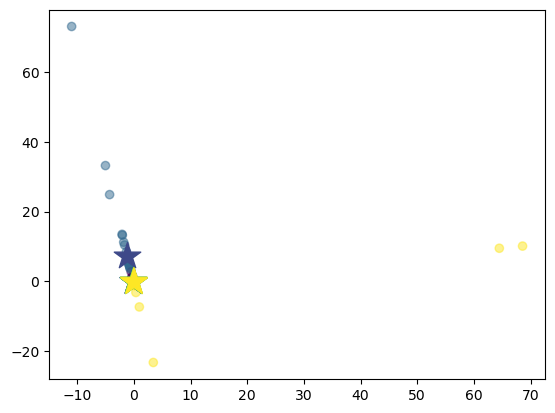

In [23]:
# kNN with 3 neighbors
seed(2022)
kNN_alg1 = KNeighborsClassifier(n_neighbors=3)
kNN_alg1.fit(label_data,pt_label)
preds1 = kNN_alg1.predict(unlabeled[:,1:])

# plot the prediction
plt.scatter(unlabeled[:,1], unlabeled[:,2], c=preds1, alpha = 0.5)
plt.scatter(label_data[:,0], label_data[:,1], c=pt_label, s = 400, marker = '*')

print("10-fold cross-validation error for 3NN is: ", kNN_kfold_CV(3,train_2D,10))

We can see from the results above that kNN misclassified most of the data points within the test set. This might be due to the fact that most of the data points are stacked closely together and referencing the closest neighbors does not help with identifying the correct class for the data set. Also we only sampled 10 data points from the total of 2029 data points which does not give us as much information.

### Decision Tree

For the Decision Tree classifier, we input the coordinates and the corresponding label to fit the model.

In [15]:
# split the data into info and label
info = train[:,1:]
label = train[:,0]

# Specify the model
dt = DecisionTreeClassifier()

# Fit the model to the data
dt.fit(info, label)

DecisionTreeClassifier()

In [20]:
# visualize the decision tree
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, feature_names=var_names)
(dt_vis, ) = graph_from_dot_data(dot_data.getvalue())

Image(dt_vis.create_png())

In [28]:
# 10-fold cross-validation
kfold_CV(train, dt, 10)

0.6875067555395424

Compared to kNN, decision tree has a better performance in terms of cross-validation errors. Still, the algorithm was only able to correctly predict about 32\% of the total ratings.

### Random Forest
Here we build a random forest of 3 decision trees that each takes in at most 8 features (we have 25 features in total, in order to have different features for each tree, we want each tree to have at most 8 features).

In [36]:
forest = RandomForestClassifier(n_estimators=3, max_features = 8, max_depth=5, random_state=0)
forest.fit(info, label)

RandomForestClassifier(max_depth=5, max_features=8, n_estimators=3,
                       random_state=0)

In [37]:
# cross-validation for random forest
kfold_CV(train, forest, 10)

0.6240437158469946

Of the three classification methods we've implemented, it seems that random forest has the best accuracy in terms of 10-fold cross-validation error. Though still not good enough, the random forest is able to correctly classify around 38\% of the credit ratings for the companies within the test data in cross-validation. Therefore we choose to go with the random forest model and fit it on the entire training set to get the exact parameters.

## Fit the model on the training set

In [38]:
forest = RandomForestClassifier(n_estimators=3, max_features = 8, max_depth=5, random_state=0)
forest.fit(info, label)

RandomForestClassifier(max_depth=5, max_features=8, n_estimators=3,
                       random_state=0)

In [40]:
print(var_names)
print(forest.feature_importances_)

Index(['currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed',
       'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover',
       'debtEquityRatio', 'debtRatio', 'effectiveTaxRate',
       'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare',
       'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue',
       'enterpriseValueMultiple', 'operatingCashFlowPerShare',
       'operatingCashFlowSalesRatio', 'payablesTurnover'],
      dtype='object')
[0.01609597 0.02914652 0.03394132 0.01018814 0.04819901 0.07680275
 0.02384989 0.00621593 0.13012723 0.04997443 0.00853634 0.02000688
 0.05159732 0.02292042 0.06696411 0.02856266 0.02518897 0.03006095
 0.03634783 0.05429576 0.0224278  0.06398323 0.12077219 0.
 0.02379434]


Printing all the attributes and their corresponding importance, it seems that the most important feature regarding a company's credit rating is its return on assets, followed by the operating cash flow per share. It seems that the company's profitability and liquidity are highly correlated with its credit rating. 

## Test set prediction

In [43]:
test_preds = forest.predict(test[:,1:])
print("The classficiation of the random forest on the test set is: ",classification_mse(test[:,0], test_preds))

The classficiation of the random forest on the test set is:  0.5841584158415841


Compared to the accuracy in predicting the credit ratings for the training set, the random forest classifier has a relatively higher accuracy in terms of predicting the credit ratings for companies in the test set. The model is able to correctly classify around 42\% of the total ratings for the 202 companies in the test set. 

## Summary

Overall, of the three classification models we've implemented(kNN, decision tree, and random forest), random forest classifier has the best performance in terms 10-fold cross-validation error. After fitting the random forest classifier on the entire training set, the model is able to corrrectly classify around 42\% of the ratings for the companies within the test set. However, none of the three models is able to have a prediction accuracy over 50\%. This could be due to the inbalanced nature of the data and the small sample size. Future improvements of this project includes fitting the model on bigger, more balanced data, and implementing other classification algorithms such as different kernels of SVM on the data to improve classification accuracy.

### References
- Converting categorical values to numbers https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
- Sample data after groupby https://stackoverflow.com/questions/36390406/sample-each-group-after-pandas-groupby
- Differece between two 2D numpy arrays https://stackoverflow.com/questions/66674537/python-numpy-get-difference-between-2-two-dimensional-array